## Data Description 
--> Providing first insights into the data using the filtered data:
- How many articles are there? By how many and which newspapers were they published?
- In which ressorts are the articles published?
- When are articles published?
- How long are the artiles?


## Imports and Paths

In [1]:
# imports
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm 
from datetime import datetime
from ast import literal_eval

In [2]:
# connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# change cwd
%cd drive/MyDrive/Work/Frontline/data
#%cd /content/drive/MyDrive/data/

/content/drive/.shortcut-targets-by-id/1WfnZsqpG1r110J63sMbfS5TpsDOkveiV/data


In [8]:
# paths
FILTERED_PATH="filtered_4_26"

## Read & Combine Data


In [9]:
dfs = []

# loop through files 
for filename in os.listdir(FILTERED_PATH):
    # if csv file, load and add to dfs  
    if filename.endswith(".csv"):
        file_path = os.path.join(FILTERED_PATH, filename)
        df = pd.read_csv(file_path, index_col=0, converters={"text":literal_eval})
        dfs.append(df)

# combine files in df
df = pd.concat(dfs, ignore_index=True)

## Data  and Plots

### Wie viele Artikel gibt es über häusliche Gewalt?

In [10]:
print(f"Es gibt {len(df)} Artikel zum Thema häusliche Gewalt, die in {len(df.name.value_counts())} Zeitungen erschienen")

Es gibt 63359 Artikel zum Thema häusliche Gewalt, die in 179 Zeitungen erschienen


### Wie viele Artikel veröffentlichen Zeitungen über häusliche Gewalt?




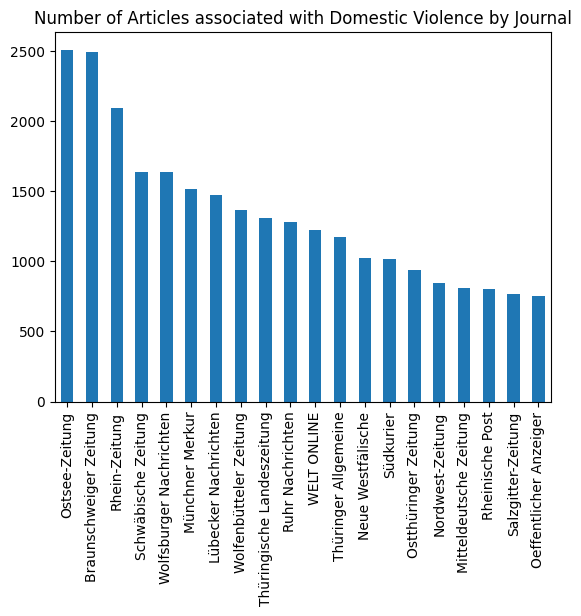

In [11]:
df["name"].value_counts()[:20].plot(kind="bar", title="Number of Articles associated with Domestic Violence by Journal");

In [12]:
df["name"].value_counts() 

Ostsee-Zeitung             2509
Braunschweiger Zeitung     2489
Rhein-Zeitung              2094
Schwäbische Zeitung        1638
Wolfsburger Nachrichten    1635
                           ... 
ZEIT Wissen                   2
Audio Video Foto Bild         2
Spiegel Start                 1
ZEIT Geschichte               1
ZEIT Studienführer            1
Name: name, Length: 179, dtype: int64

###In welchen Ressorts wird veröffentlicht?


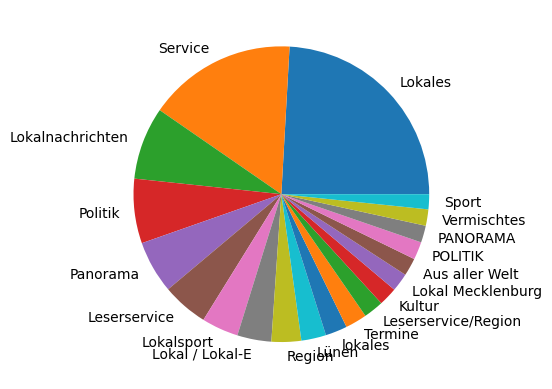

In [13]:
plt.pie(df.ressort.value_counts()[:20],labels =df.ressort.value_counts()[:20].index);

###Wann werden Zeitungen veröffentlicht?

In [14]:
## articles without date
df.datum.isna().sum()

0

In [15]:
dates=df[~df.datum.isna()].datum.astype(int)
dates=pd.to_datetime(dates, format="%Y%m%d")

In [16]:
#create a monthy aggregation of the articles
dates_month=[i.to_period("M") for i in dates]
months=[x.to_period("M") for x in pd.date_range(dates.min().date(),dates.max().date(), freq='MS')]
# set the value to 0 for all the remaining months
missing_months=[(x,0) for x in months if x not in dates_month]
dates_month_counter=dict(Counter(dates_month))
dates_month_counter.update(dict(missing_months))

In [17]:
dates_month_counter=pd.DataFrame.from_dict(dates_month_counter, orient="index")[0]

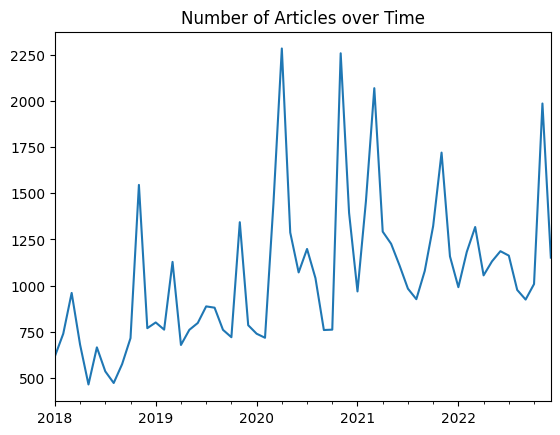

In [18]:
dates_month_counter.sort_index().plot(title="Number of Articles over Time",);

###What are the peaks? (95%-quantiles)

In [19]:
dates_month_counter[dates_month_counter>dates_month_counter.quantile(0.95)].sort_index()

2020-04    2284
2020-11    2258
2021-03    2069
Freq: M, Name: 0, dtype: int64

###Länge der Artikel

In [20]:
lengths=[len(("".join(i).split(" "))) for i in df.text]
lengths_rounded=[round(i)for i in lengths]

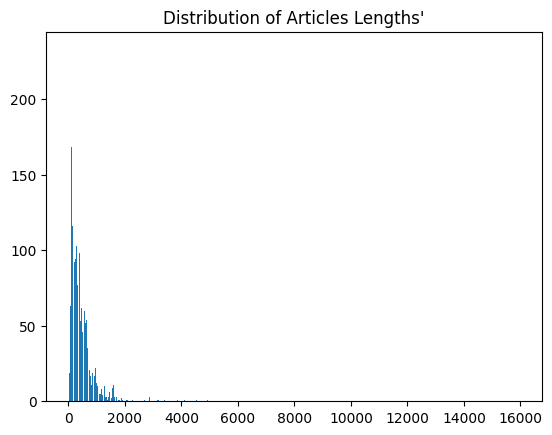

In [21]:
plt.bar(dict(Counter(lengths_rounded)).keys(),dict(Counter(lengths_rounded)).values());
plt.title("Distribution of Articles Lengths'");

###Are there outliers?

In [22]:
idx=[i>10000 for i in lengths]
print(f"{df[idx].shape[0]} articles have a length of >10000 words")


3 articles have a length of >10000 words


In [23]:
idx=[i>2000 for i in lengths]
print(f"{df[idx].shape[0]} articles have a length of >2000 words")

606 articles have a length of >2000 words


## In Depth: Länge der Artikel, Paragraphen


### Methods

In [32]:
import statistics
import re

In [37]:
# function to count sentences and get summary statistics
def count_sentences(arts):
  sentence_counts=[]
  for art in tqdm(arts):
    # split on full stop, not when number proceeding, eg. 30. November
    # counting sentences
    sentence_counts=sentence_counts+[len(re.split("(?<!\d)\.", paragraph)) for paragraph in art]
  return {'mean': statistics.mean(sentence_counts),
          'max': max(sentence_counts),
          'min': min(sentence_counts),
          'mode': statistics.mode(sentence_counts)},sentence_counts

In [44]:
def count_words(arts):
  word_counts=[]
  for art in tqdm(arts):
    # counting words in paragraph
    word_counts=word_counts+[len(paragraph.split()) for paragraph in art]
  return {'mean': statistics.mean(word_counts),
          'max': max(word_counts),
          'min': min(word_counts),
          'mode': statistics.mode(word_counts)},word_counts

### Length of paragraphs before cleaning


In [38]:
summary,sentence_count = count_sentences(df["text"])
print("Sentence length before cleaning:", summary)

100%|██████████| 63359/63359 [04:35<00:00, 229.58it/s]


Sentence length before cleaning: {'mean': 2.2732662652409847, 'max': 277, 'min': 1, 'mode': 1}


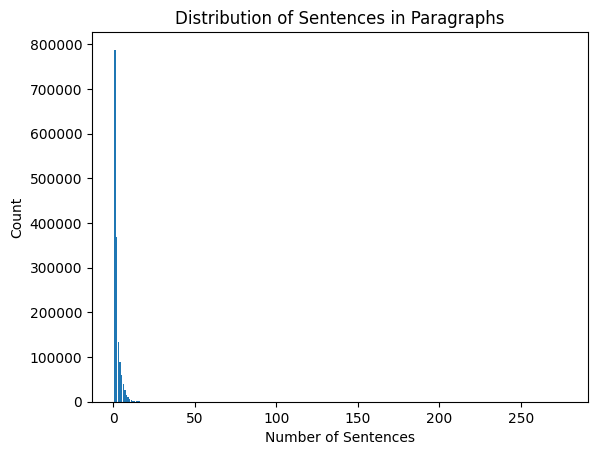

In [39]:
plt.bar(dict(Counter(sentence_count)).keys(),dict(Counter(sentence_count)).values());
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Paragraphs');

Checking quantiles

In [40]:
pd.DataFrame(sentence_count).quantile([0.5,0.9,0.95,0.99])

,0
0.50,1.0
0.90,5.0
0.95,6.0
0.99,10.0


Observations:
- max number fo sentences in paragraph is ~230 
- 90% of all paragraphs have 5 or fewer sentences
- 99% of paragraphs have 10 or fewer sentences

Let's look at articles above the 95%- quantile

In [ ]:
for art in df["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(re.split("(?<!\d)\.", paragraph))>6:
      print(paragraph)

Onservations:
- long sentence paragraphs are either
  - very short sentences, graphic language, sensational language --> relevant
  - long sentences, descriptive --> too long
--> use number of words instead

### Number of words in articles

In [45]:
summary,word_count = count_words(df["text"])
print("Sentence length before cleaning:", summary)

100%|██████████| 63359/63359 [03:01<00:00, 348.84it/s]


Sentence length before cleaning: {'mean': 18.241860266617007, 'max': 3653, 'min': 0, 'mode': 1}


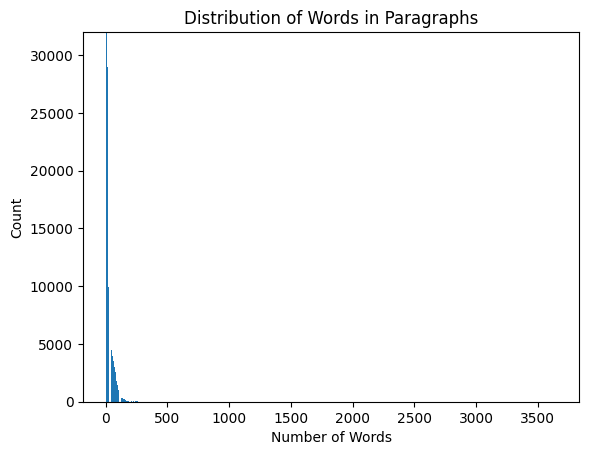

In [46]:
plt.bar(dict(Counter(word_count)).keys(),dict(Counter(word_count)).values());
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.ylim([0, 32000])
plt.title('Distribution of Words in Paragraphs');

Checking quantiles

In [47]:
pd.DataFrame(word_count).quantile([0.5,0.9,0.95,0.99])

,0
0.50,7.0
0.90,53.0
0.95,76.0
0.99,127.0


Observations:
- most paragraphs contain less than 50 words
- half of the paragraphs contain <=7 words


Let's look at the 95% quantile paragraphs:

In [ ]:
for art in df["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(paragraph.split())>75:
      print(paragraph)

Let's look at the 99% quantile paragraphs:

In [ ]:
for art in df["text"].iloc[:10]:
  for paragraph in art:
    # split on full stop, not when number proceeding, eg. 30. November
    if len(paragraph.split())>127:
      print(paragraph)

Observations:
- 75 words paragraphs are ususlly not too long
- 127+ words are fairly long

--> exclude paragraph if exceeds 125 words

### Explode by paragraphs

In [51]:
# Explode "text" column
df_exploded= df.explode("text")
# Create "artikel_order" column
df_exploded["artikel_order"] = df_exploded.groupby("artikel_id").cumcount() + 1


### Inspect paragraphs by length

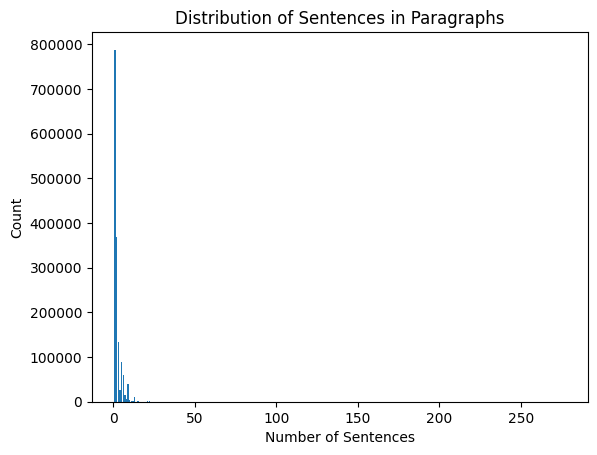

In [52]:
# Get number of sentences
df_exploded['num_sentences']=[len(re.split("(?<!\d)\.", paragraph)) for paragraph in df_exploded['text']]

# # # Create a bar chart
plt.bar(df_exploded['num_sentences'].unique(), df_exploded['num_sentences'].value_counts())

# # Set axis labels and title
plt.xlabel('Number of Sentences')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Paragraphs');


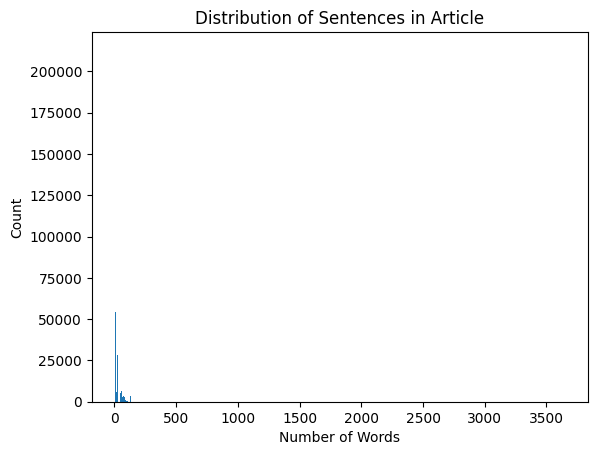

In [53]:
# Get number of Words
df_exploded['num_words']=[len(paragraph.split()) for paragraph in df_exploded['text']]

# Create a bar chart
plt.bar(df_exploded['num_words'].unique(), df_exploded['num_words'].value_counts())

# Set axis labels and title
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.title('Distribution of Sentences in Article');